# Map Converter
This is a Jupyter Notebook to Convert a `.png` or `.pgm` + `.yaml` of a map into a `.csv` that can be fed into the TUMFTM functions.

Here is a high level overview of how this works:
1. We load the image and extract the left and right edges of the track
2. Associate inner lines with outer lines
3. Apply the right transformations

We need to generate the following 4 columns:`x_m,y_m,w_tr_right_m,w_tr_left_m`

Maps supported:
- Black and white
- White and black

We can automatically detect what kind of map it is. 

Map Conditions:
- Map must be aligned somewhat in the center of the image (i.e. cannot just be in the top left, else algorithm will not find edges)
- Map should be closed and clean

You still need to manually check the map to make sure it is correct.
- Just check the starting positions, sometimes that doesn't work

In [436]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy.ndimage import distance_transform_edt as edt
from PIL import Image
import os

In [437]:
MAP_NAME = "Spielberg_map"

In [439]:
# Modified from https://github.com/CL2-UWaterloo/Head-to-Head-Autonomous-Racing/blob/main/gym/f110_gym/envs/laser_models.py
# load map image

if os.path.exists(f"{MAP_NAME}.png"):
    map_img_path = f"{MAP_NAME}.png"
elif os.path.exists(f"{MAP_NAME}.pgm"):
    map_img_path = f"{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"{MAP_NAME}.yaml"
map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
map_img = map_img.astype(np.float64)

# grayscale -> binary
map_img[map_img <= 128.] = 0.
map_img[map_img > 128.] = 255.

map_height = map_img.shape[0]
map_width = map_img.shape[1]




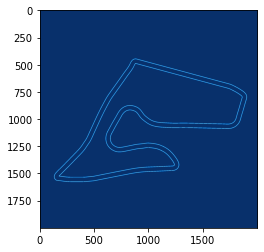

In [440]:
plt.imshow(map_img, cmap='Blues')

In [441]:
NON_EDGE = np.bincount(map_img.ravel().astype(np.int64)).argmax()
print(f"Non-edge value: {NON_EDGE}")
# Use DFS to extract the outer edge
left_start_y = map_height // 2
left_start_x = 0
while (map_img[left_start_y][left_start_x] == NON_EDGE): 
	left_start_x += 1

print(f"Starting position for left edge: {left_start_x} {left_start_y}")

Non-edge value: 255
Starting position for left edge: 508 1000


Solution is to do a smart DFS, in the direction of the current search. First consider options in the direction of the current search, then consider options in the opposite direction (exclude exactly oppposite direction). 
- Was trying to only do 90 degrees max, but then there are edge cases where that doesn't work

Termination condition? 
- If you hit a pixel that has already been visited, then you have found the end of the track.

Things that were tried:
- Naive BFS/DFS: If you set the termination condition to having visited all edge nodes, you have no guarantees on the order of the pixels. BFS doesn't give you the order of track progress. DFS does, but in the case of multiple pixels, you don't want to capture that information.
	-  Which is why we set the termination condition to visiting a visited node

In [452]:
import sys
sys.setrecursionlimit(20000)

# [0, 0] is in the top left corner
NORTH = [0, -1]
NORTH_EAST = [1, -1]
EAST = [1, 0]
SOUTH_EAST = [1, 1]
SOUTH = [0, 1]
SOUTH_WEST = [-1, 1]
WEST = [-1, 0]
NORTH_WEST = [-1, -1]

HEADINGS = [NORTH, NORTH_EAST, EAST, SOUTH_EAST, SOUTH, SOUTH_WEST, WEST, NORTH_WEST]
HEADINGS_KEY = [[NORTH, NORTH_WEST, NORTH_EAST, WEST, EAST, SOUTH_WEST, SOUTH_EAST], #NORTH
				[NORTH_EAST, NORTH, EAST, NORTH_WEST, SOUTH_EAST, SOUTH, SOUTH_WEST], #NORTH_EAST
				[EAST, NORTH_EAST, SOUTH_EAST, NORTH, SOUTH, WEST, NORTH_WEST], #EAST
				[SOUTH_EAST, EAST, SOUTH, NORTH_EAST, SOUTH_WEST, NORTH, NORTH_WEST], #SOUTH_EAST
				[SOUTH, SOUTH_EAST, SOUTH_WEST, EAST, WEST, NORTH_EAST, NORTH_WEST], #SOUTH
				[SOUTH_WEST, SOUTH, WEST, SOUTH_EAST, NORTH_WEST, EAST, NORTH_EAST], #SOUTH_WEST
				[WEST, SOUTH_WEST, NORTH_WEST, SOUTH, NORTH, SOUTH_EAST, NORTH_EAST], #WEST
				[NORTH_WEST, WEST, NORTH, SOUTH_WEST, NORTH_EAST, SOUTH, SOUTH_EAST]] #NORTH_WEST
# HEADINGS_KEY = [[NORTH, NORTH_EAST, EAST, SOUTH_EAST, SOUTH, SOUTH_WEST, WEST, NORTH_WEST], #NORTH
# 				[NORTH_EAST, EAST, SOUTH_EAST, SOUTH, SOUTH_WEST, WEST, NORTH_WEST, NORTH], #NORTH_EAST
# 				[EAST, SOUTH_EAST, SOUTH, SOUTH_WEST, WEST, NORTH_WEST, NORTH, NORTH_EAST], #EAST
# 				[SOUTH_EAST, SOUTH, SOUTH_WEST, WEST, NORTH_WEST, NORTH, NORTH_EAST, EAST], #SOUTH_EAST
# 				[SOUTH, SOUTH_WEST, WEST, NORTH_WEST, NORTH, NORTH_EAST, EAST, SOUTH_EAST], #SOUTH
# 				[SOUTH_WEST, WEST, NORTH_WEST, NORTH, NORTH_EAST, EAST, SOUTH_EAST, SOUTH], #SOUTH_WEST
# 				[WEST, NORTH_WEST, NORTH, NORTH_EAST, EAST, SOUTH_EAST, SOUTH, SOUTH_WEST], #WEST
# 				[NORTH_WEST, NORTH, NORTH_EAST, EAST, SOUTH_EAST, SOUTH, SOUTH_WEST, WEST]] #NORTH_WEST

def dfs(x, y, prev_x, prev_y, map_img, edge_img, edge_array, debug=False):
	if debug:
		print(f"Visiting {x} {y}, prev: {prev_x} {prev_y}")
	if edge_img[y][x] == 255: # If visited already
		return (x,y)

	edge_img[y][x] = 255 # Mark as visited
	edge_array.append(np.array([x, y]))

	heading = [x-prev_x, y-prev_y]
	if heading not in HEADINGS: # Check if heading is in there
		raise Exception(f"Invalid map, must be a gap of 1, heading: {heading}")

	heading_idx = HEADINGS.index(heading)
	found = False

	# Search in a clockwise fashion
	for new_heading in HEADINGS_KEY[heading_idx]:
		new_x = x + new_heading[0]
		new_y = y + new_heading[1]

		if (map_img[new_y][new_x] != NON_EDGE):
			return dfs(new_x, new_y, x, y, map_img, edge_img, edge_array, debug)
			
	if not found:
		raise Exception("could not find closest pixel")
	


In [453]:
left_edge_img = np.zeros(map_img.shape)
left_edge_array = []
# left_end_x, left_end_y = dfs(left_start_x, left_start_y, left_start_x, left_start_y-1, map_img, left_edge_img, left_edge_array)
left_end_x, left_end_y = dfs(left_start_x, left_start_y+1, left_start_x, left_start_y, map_img, left_edge_img, left_edge_array)
print(f"Number of left edges found: {len(left_edge_array)}")

Number of left edges found: 5577


In [454]:
# Sweep across the right until we run into an edge
right_start_x = left_start_x
right_start_y = left_start_y
while (map_img[right_start_y][right_start_x] != NON_EDGE): 
	right_start_x += 1

while (map_img[right_start_y][right_start_x] == NON_EDGE): # Get to the right edge
	right_start_x += 1

print(f"Starting position for right edge: {right_start_x} {right_start_y}")

Starting position for right edge: 554 1000


In [455]:
right_edge_img = np.zeros(map_img.shape)
right_edge_array = []
right_end_x, right_end_y = dfs(right_start_x, right_start_y, right_start_x, right_start_y-1, map_img, right_edge_img, right_edge_array) 
right_end_x, right_end_y = dfs(right_start_x, right_start_y+1, right_start_x, right_start_y, map_img, right_edge_img, right_edge_array)
print(f"Number of right edges found: {len(right_edge_array)}")

Number of right edges found: 5337


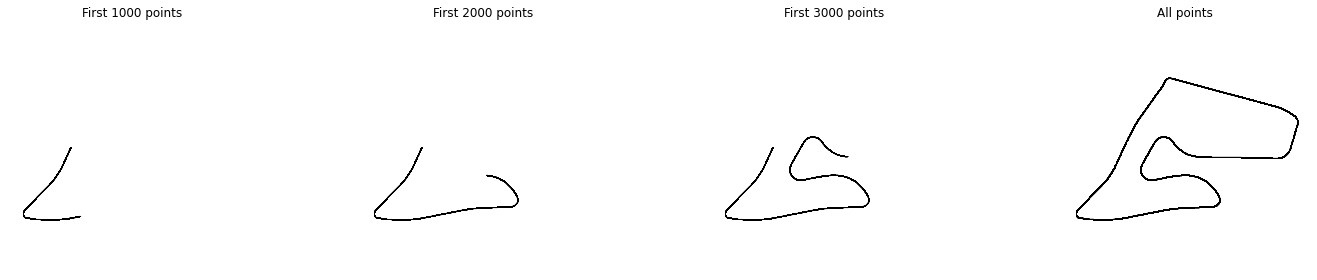

In [456]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
left_img = np.zeros(map_img.shape)
for x,y in left_edge_array[:1000]:
	left_img[y][x] = 255

ax1.imshow(left_img, cmap='Greys', vmax=1)
ax1.set_title("First 1000 points")
left_img = np.zeros(map_img.shape)
for x,y in left_edge_array[:2000]:
	left_img[y][x] = 255

ax2.imshow(left_img, cmap='Greys', vmax=1)
ax2.set_title("First 2000 points")
left_img = np.zeros(map_img.shape)
for x,y in left_edge_array[:3000]:
	left_img[y][x] = 255

ax3.imshow(left_img, cmap='Greys', vmax=1)
ax3.set_title("First 3000 points")
left_img = np.zeros(map_img.shape)
for x,y in left_edge_array:
	left_img[y][x] = 1000

ax4.imshow(left_img, cmap='Greys', vmax=1)
ax4.set_title("All points")
fig.tight_layout()

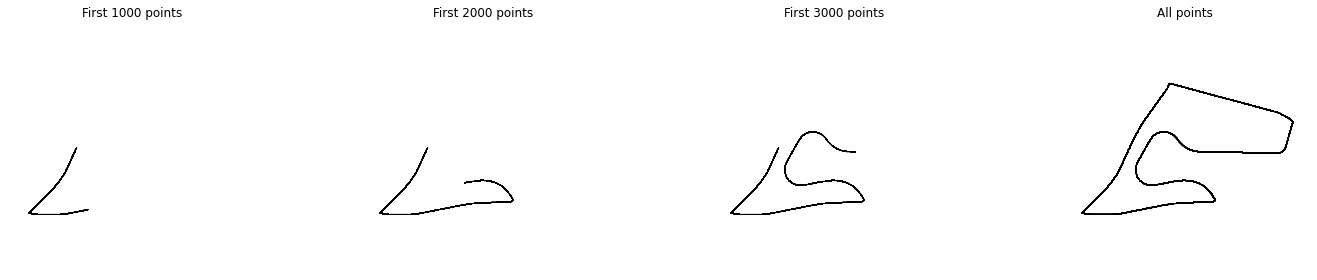

In [457]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
right_img = np.zeros(map_img.shape)
for x,y in right_edge_array[:1000]:
	right_img[y][x] = 255

ax1.imshow(right_img, cmap='Greys', vmax=1)
ax1.set_title("First 1000 points")
right_img = np.zeros(map_img.shape)
for x,y in right_edge_array[:2000]:
	right_img[y][x] = 255

ax2.imshow(right_img, cmap='Greys', vmax=1)
ax2.set_title("First 2000 points")
right_img = np.zeros(map_img.shape)
for x,y in right_edge_array[:3000]:
	right_img[y][x] = 255

ax3.imshow(right_img, cmap='Greys', vmax=1)
ax3.set_title("First 3000 points")
right_img = np.zeros(map_img.shape)
for x,y in right_edge_array:
	right_img[y][x] = 1000

ax4.imshow(right_img, cmap='Greys', vmax=1)
ax4.set_title("All points")
fig.tight_layout()

In [461]:
# Association
data = []
midpoints = []
track_widths = []
left_right_ratio = len(right_edge_array) / len(left_edge_array)
for i in range(len(left_edge_array)):
	left_edge_point = left_edge_array[i]
	right_edge_point = right_edge_array[int(i * left_right_ratio)]
	midpoint = (left_edge_point + right_edge_point) // 2
	track_widths.append(np.array([np.linalg.norm(left_edge_point - midpoint), np.linalg.norm(right_edge_point - midpoint)]))
	midpoints.append(midpoint)

print(f"Number of midpoints: {len(midpoints)}")

Number of midpoints: 5577


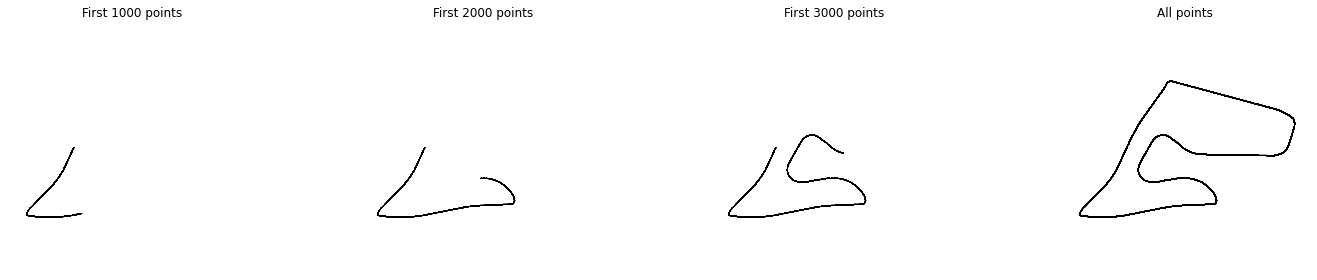

In [462]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
midpoint_img = np.zeros(map_img.shape)
for x,y in midpoints[:1000]:
	midpoint_img[y][x] = 255

ax1.imshow(midpoint_img, cmap='Greys', vmax=1)
ax1.set_title("First 1000 points")
midpoint_img = np.zeros(map_img.shape)
for x,y in midpoints[:2000]:
	midpoint_img[y][x] = 255

ax2.imshow(midpoint_img, cmap='Greys', vmax=1)
ax2.set_title("First 2000 points")
midpoint_img = np.zeros(map_img.shape)
for x,y in midpoints[:3000]:
	midpoint_img[y][x] = 255

ax3.imshow(midpoint_img, cmap='Greys', vmax=1)
ax3.set_title("First 3000 points")
midpoint_img = np.zeros(map_img.shape)
for x,y in midpoints:
	midpoint_img[y][x] = 1000

ax4.imshow(midpoint_img, cmap='Greys', vmax=1)
ax4.set_title("All points")
fig.tight_layout()

# Conversion
Convert into Pandas, and go from pixels to meters, and then shift by the origin.

In [473]:
track_widths_np = np.array(track_widths)
waypoints = np.array(midpoints)
print(f"Track widths shape: {track_widths_np.shape}, waypoints shape: {waypoints.shape}")

Track widths shape: (5577, 2), waypoints shape: (5577, 2)


In [474]:
# Merge track with waypoints
data = np.concatenate((waypoints, track_widths_np), axis=1)
data.shape

(5577, 4)

In [477]:

# load map yaml
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = data
transformed_data *= map_resolution
transformed_data += np.array([orig_x, orig_y, 0, 0])

In [479]:
with open(f"{MAP_NAME}.csv", 'wb') as fh:
    np.savetxt(fh, transformed_data, fmt='%0.4f', delimiter=',', header='x_m,y_m,w_tr_right_m,w_tr_left_m')